# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [24]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

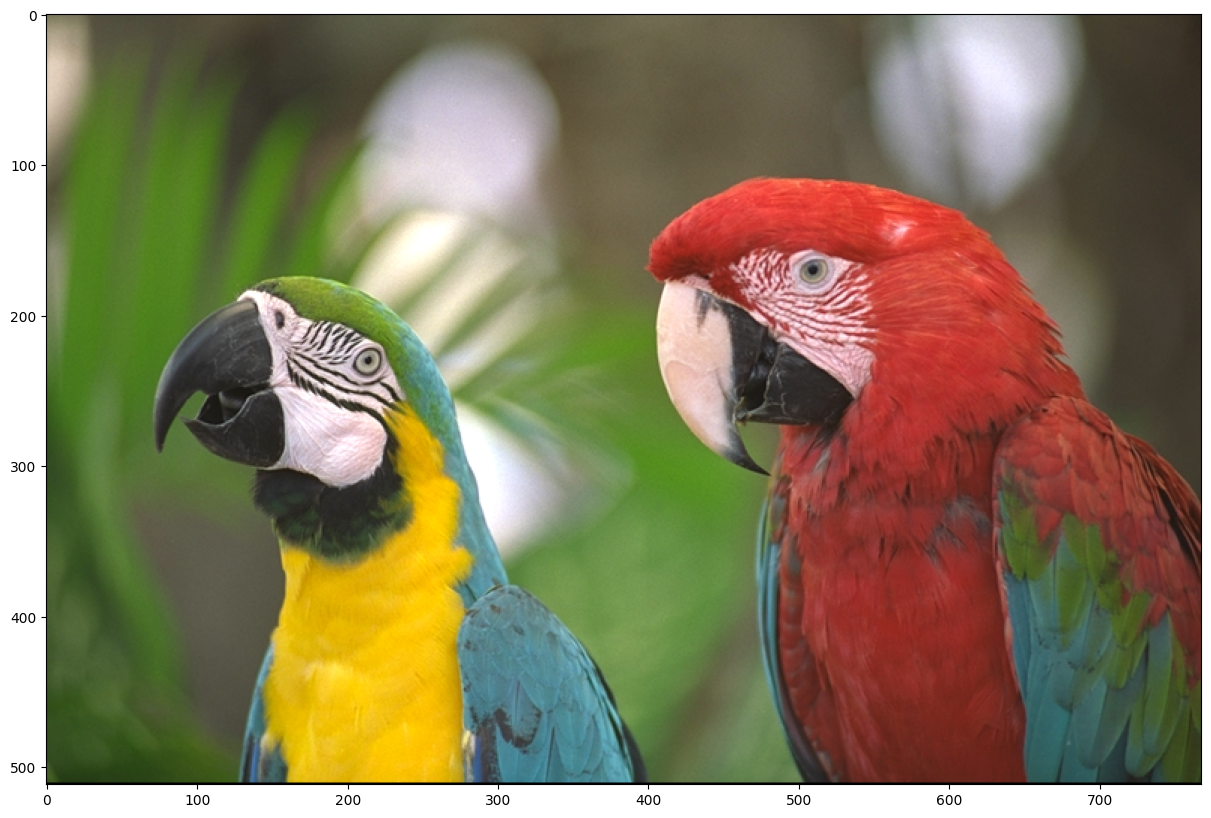

In [25]:
# Load image
img = cv2.imread('kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [26]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])
colors_float = colors.astype(np.float32) / 255.0 

Using the colour pallette, let's quantize the original image.

In [27]:
def find_closest_color(palette, target_color):
    # Calculate the distance between each color in the palette and the target color
    distances = np.sqrt(np.sum((palette - target_color) ** 2, axis=1))
    
    # Find the index of the minimum distance
    closest_color_index = np.argmin(distances)
    
    return palette[closest_color_index]

(<Axes: title={'center': 'Quantized'}>,
 Text(0.5, 1.0, 'Quantized'))

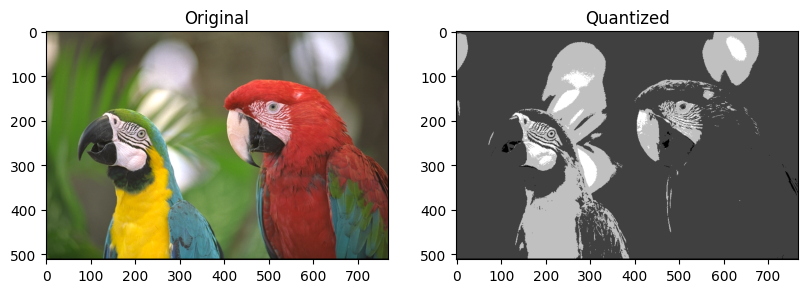

In [28]:
# Cast the image to float
img_float = img.astype(np.float32)
img_float = img_float / 255.

# Prepare for quantization
rows, cols, channels = img_float.shape
quantized = np.zeros_like(img_float)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img_float[r, c]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = find_closest_color(colors_float, pixel)
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

plt.subplot(131), plt.imshow(img_float), plt.title('Original')
plt.subplot(132), plt.imshow(quantized), plt.title('Quantized')

In [29]:
# Compute average quantization error
total_quant_error = np.sum(np.abs(img.astype(np.float32) - quantized.astype(np.float32)))
avg_quant_error = total_quant_error / (img.shape[0] * img.shape[1])


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [30]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img_float)
dithering = np.zeros_like(img_float)
total_quant_error = 0

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = find_closest_color(colors_float, pixel)
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        total_quant_error += abs(quant_error)
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp[r + 1, c    ] += quant_error * 7 / 16
        img_tmp[r - 1, c + 1] += quant_error * 3 / 16
        img_tmp[r    , c + 1] += quant_error * 5 / 16
        img_tmp[r + 1, c + 1] += quant_error * 1 / 16
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

(<Axes: title={'center': 'Dithering \n(error - [0.5417497  0.43052426 0.5717787 ])'}>,
 Text(0.5, 1.0, 'Dithering \n(error - [0.5417497  0.43052426 0.5717787 ])'))

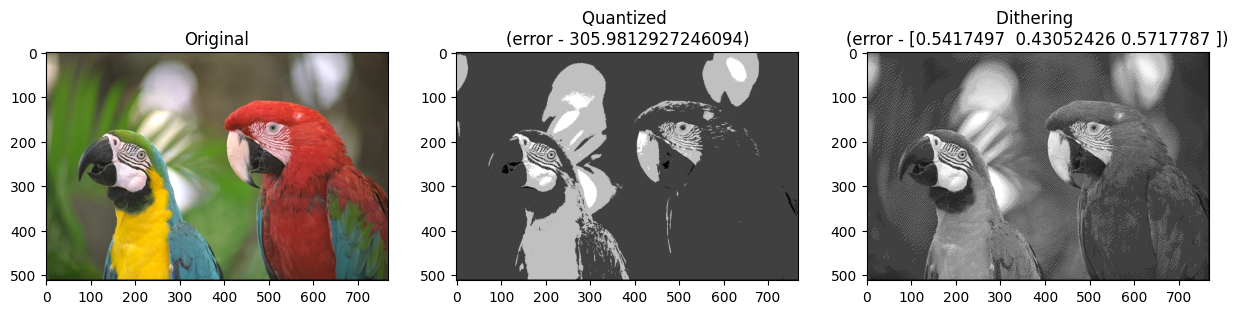

In [31]:
# Compute average quantization error for dithered image
avg_dith_error = total_quant_error / (img.shape[0] * img.shape[1])

### Questions
#### Which image has higher quantization error? Optimally quantized or dithered?
####
**Dithered image** обычно имеет большую ошибку квантования при численном измерении. Это происходит потому, что dithered алгоритм намеренно вводит небольшой визуальный шум,чтобы распределить ошибку квантования по соседним пикселям, что помогает сохранить визуальную детализацию

#### Which image looks better to you?
####
**Dithered image** обычно выглядит лучше. Хотя средняя ошибка может быть выше, визуальный вид улучшается за счет распределения ошибки по всему изображению, что делает его более естественным и уменьшает резкие переходы между различными уровнями цвета.

#### Can you repeat the same process using only two colours: black and white? Show me :-)
#### 
Да, процесс можно повторить, используя только два цвета: черный и белый. Ниже приведена модифицированная версия алгоритма в виде одного метода, который принимает изображение и цветовую палитру, а возвращает квантованное и сглаженное изображения

In [41]:
# Black, dark gray, light gray, white
def apply_dithering(image, colors):
    colors_float = colors.astype(np.float32) / 255.0
    
    img_float = image.astype(np.float32)
    img_float = img_float / 255.
    
    # Prepare for quantization
    rows, cols, channels = img_float.shape
    quantized = np.zeros_like(img_float)
    
    # Apply quantization
    for r in range(rows):
        for c in range(cols):
            pixel = img_float[r, c]
            new_pixel = find_closest_color(colors_float, pixel)
            quantized[r, c, :] = new_pixel
    
    img_tmp = np.copy(img_float)
    dithering = np.zeros_like(img_float)
    
    # Apply dithering
    for r in range(1, rows-1):
        for c in range(1, cols-1):
            pixel = img_tmp[r, c]
            new_pixel = find_closest_color(colors_float, pixel)
            
            quant_error = pixel - new_pixel
            img_tmp[r + 1, c    ] += quant_error * 7 / 16
            img_tmp[r - 1, c + 1] += quant_error * 3 / 16
            img_tmp[r    , c + 1] += quant_error * 5 / 16
            img_tmp[r + 1, c + 1] += quant_error * 1 / 16
            
            dithering[r, c, :] = new_pixel
    return quantized, dithering

(<Axes: title={'center': 'Dithering Black and White'}>,
 Text(0.5, 1.0, 'Dithering Black and White'))

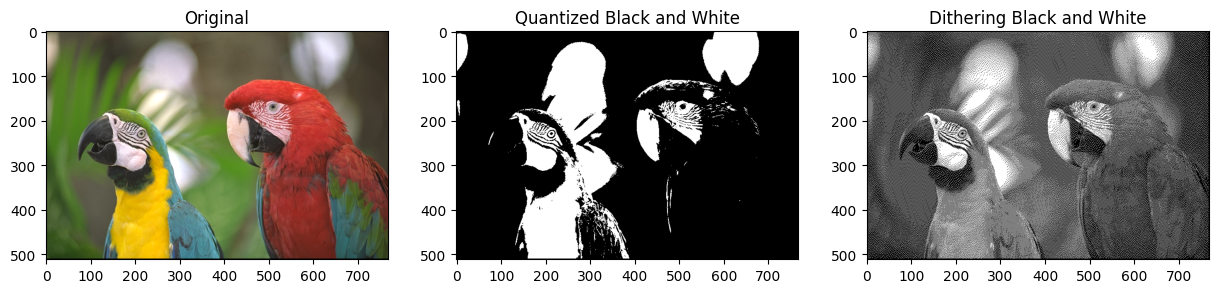

In [44]:
colors = np.array([[0, 0, 0],
                   [255, 255, 255]])

img = cv2.imread('kodim23.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

quantized, dithering = apply_dithering(img, colors)

plt.subplot(131), plt.imshow(img), plt.title('Original')   # original
plt.subplot(132), plt.imshow(quantized), plt.title(f'Quantized Black and White')  # optimally quantized
plt.subplot(133), plt.imshow(dithering), plt.title(f'Dithering Black and White')  # dithering

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

#### Custom colors

(<Axes: title={'center': 'Palette (4 colors)'}>,
 Text(0.5, 1.0, 'Palette (4 colors)'))

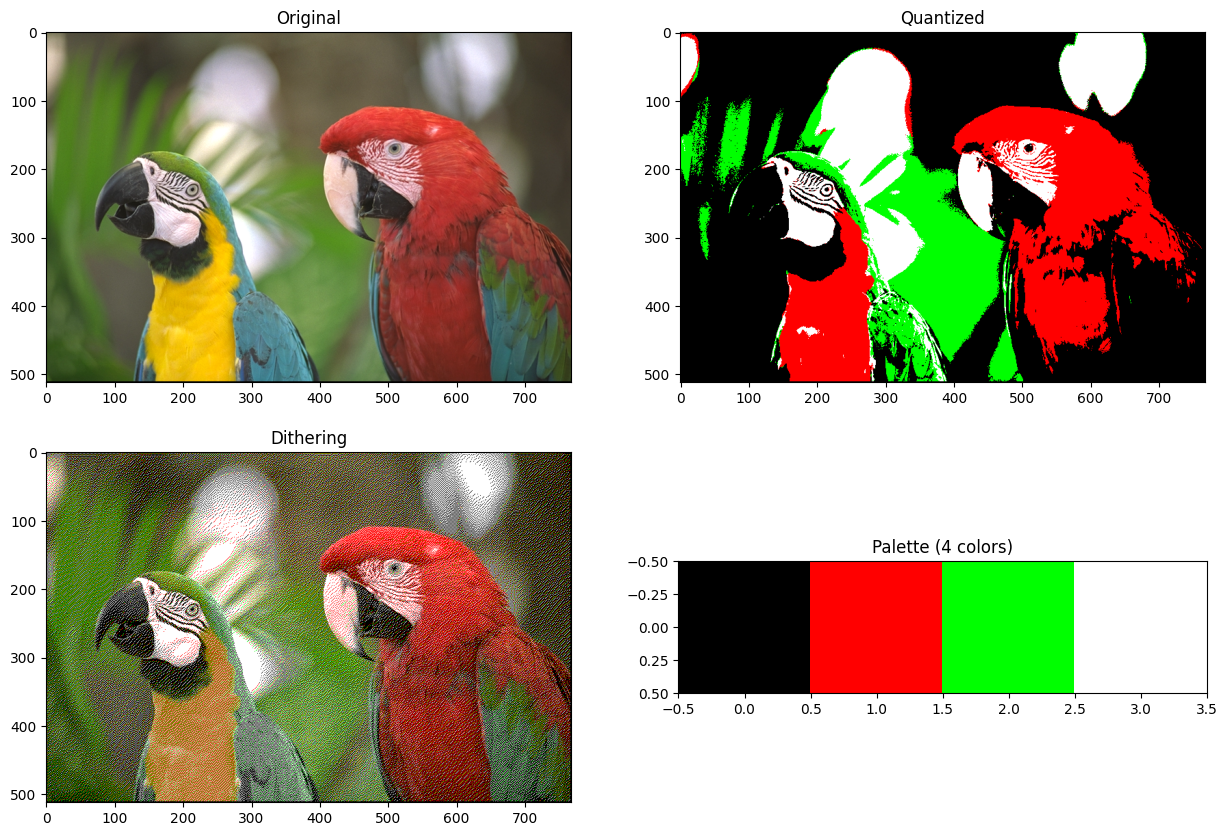

In [94]:
colors = np.array([
                   [0, 0, 0],
                   [255, 0, 0],
                   [0, 255, 0],
                   # [0, 0, 255],
                   [255, 255, 255]
                   ])
colors_image = np.reshape(colors, (1, len(colors), 3))

img = cv2.imread('kodim23.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

quantized, dithering = apply_dithering(img, colors)

plt.subplot(221), plt.imshow(img), plt.title('Original')   # original
plt.subplot(222), plt.imshow(quantized), plt.title(f'Quantized')  # optimally quantized
plt.subplot(223), plt.imshow(dithering), plt.title(f'Dithering')  
plt.subplot(224), plt.imshow(colors_image), plt.title(f'Palette ({len(colors)} colors)')

#### Optimal colors

(<Axes: title={'center': 'Palette - 16 colors'}>,
 Text(0.5, 1.0, 'Palette - 16 colors'))

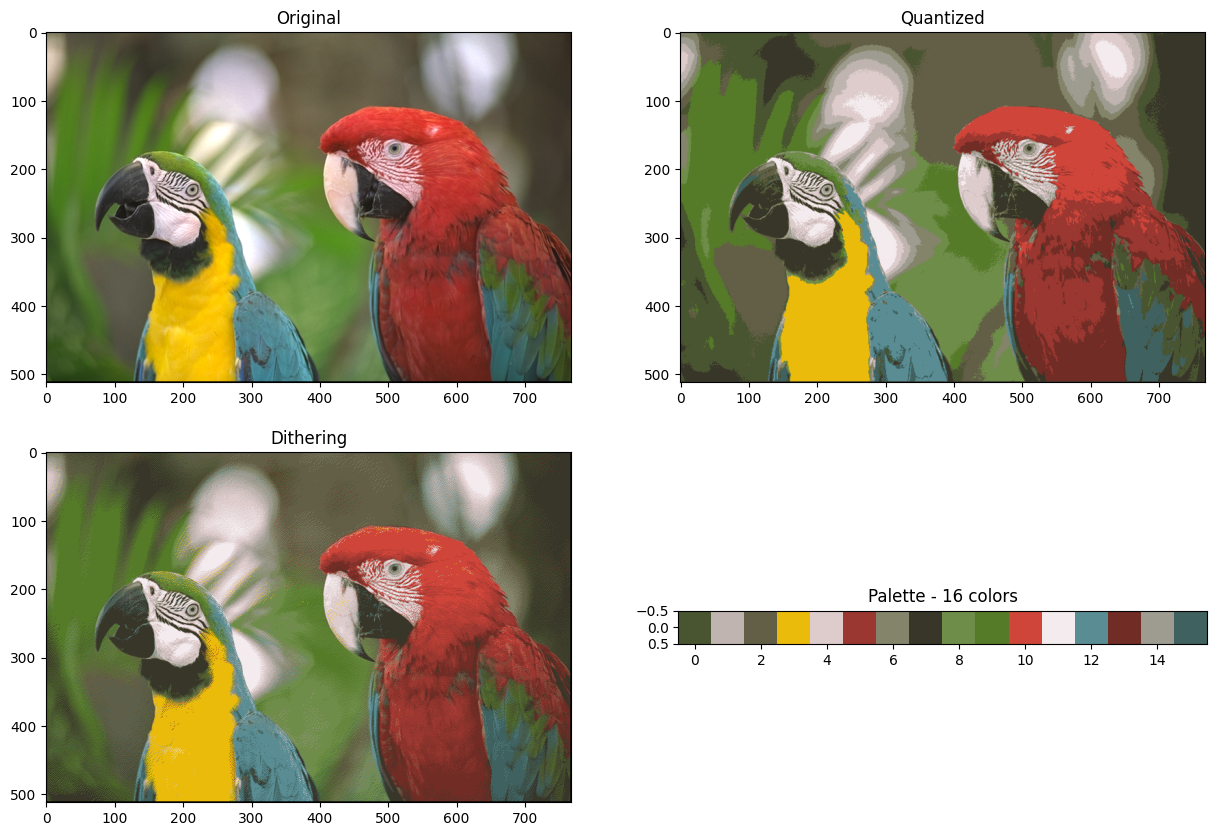

In [92]:
from sklearn.cluster import KMeans
img = cv2.imread('kodim23.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

kmeans = KMeans(n_clusters=16).fit(img.reshape((-1, 3)))
palette = kmeans.cluster_centers_.astype(int)

num_cols = 16
colors_image = np.reshape(palette, ((len(palette) + num_cols - 1) // num_cols, num_cols, 3))

quantized, dithering = apply_dithering(img, palette)

plt.subplot(221), plt.imshow(img), plt.title('Original')   # original
plt.subplot(222), plt.imshow(quantized), plt.title(f'Quantized')  # optimally quantized
plt.subplot(223), plt.imshow(dithering), plt.title(f'Dithering')  
plt.subplot(224), plt.imshow(colors_image), plt.title(f'Palette ({len(palette)} colors)')

(<Axes: title={'center': 'Palette (32 colors)'}>,
 Text(0.5, 1.0, 'Palette (32 colors)'))

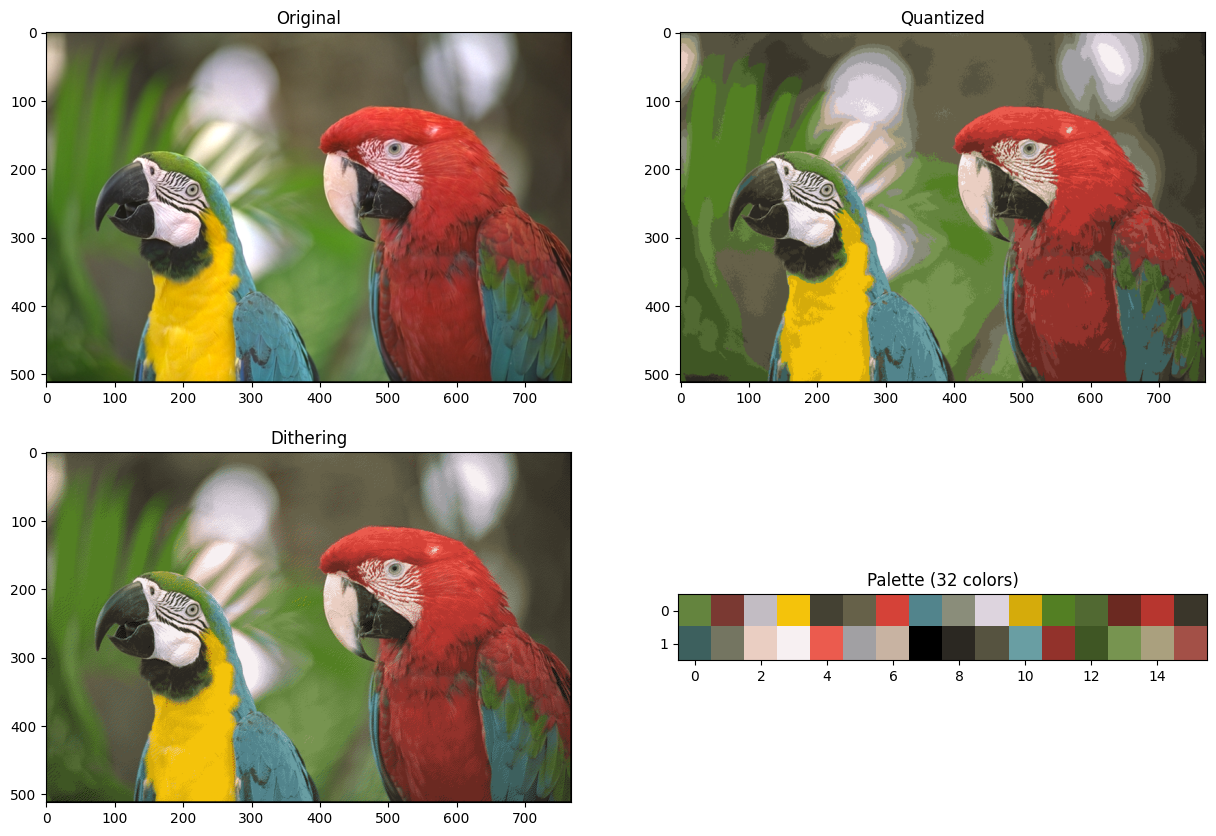

In [93]:
from sklearn.cluster import KMeans
img = cv2.imread('kodim23.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

kmeans = KMeans(n_clusters=32).fit(img.reshape((-1, 3)))
palette = kmeans.cluster_centers_.astype(int)

num_cols = 16
colors_image = np.reshape(palette, ((len(palette) + num_cols - 1) // num_cols, num_cols, 3))

quantized, dithering = apply_dithering(img, palette)

plt.subplot(221), plt.imshow(img), plt.title('Original')   # original
plt.subplot(222), plt.imshow(quantized), plt.title(f'Quantized')  # optimally quantized
plt.subplot(223), plt.imshow(dithering), plt.title(f'Dithering')  
plt.subplot(224), plt.imshow(colors_image), plt.title(f'Palette ({len(palette)} colors)')

(<Axes: title={'center': 'Palette (256 colors)'}>,
 Text(0.5, 1.0, 'Palette (256 colors)'))

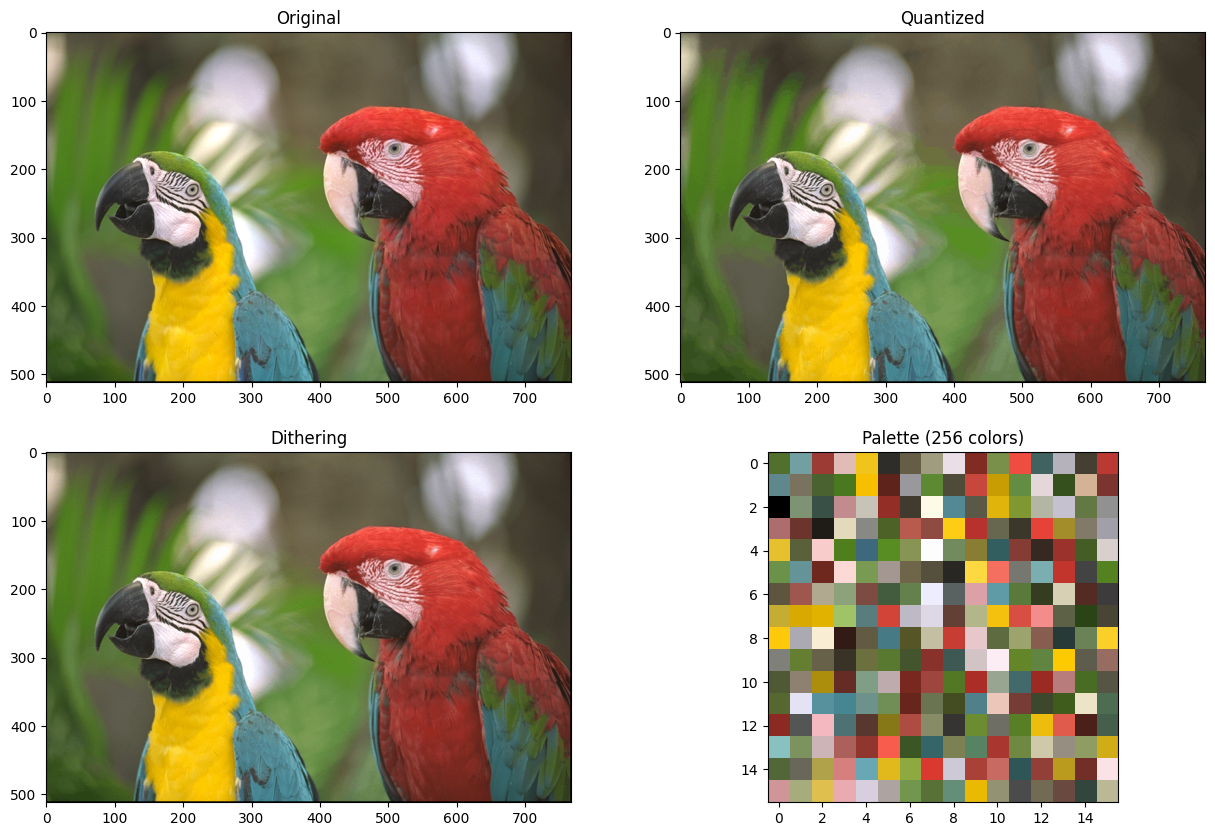

In [91]:
from sklearn.cluster import KMeans
img = cv2.imread('kodim23.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

kmeans = KMeans(n_clusters=256).fit(img.reshape((-1, 3)))
palette = kmeans.cluster_centers_.astype(int)

num_cols = 16
colors_image = np.reshape(palette, ((len(palette) + num_cols - 1) // num_cols, num_cols, 3))

quantized, dithering = apply_dithering(img, palette)

plt.subplot(221), plt.imshow(img), plt.title('Original')   # original
plt.subplot(222), plt.imshow(quantized), plt.title(f'Quantized')  # optimally quantized
plt.subplot(223), plt.imshow(dithering), plt.title(f'Dithering')  
plt.subplot(224), plt.imshow(colors_image), plt.title(f'Palette ({len(palette)} colors)')

Apply FS dithering the same way you did before.
#### How does the result look like to you?
####
Для палитры из 16 оптимальных цветов изображение смотрится неплохо. Однако, в отдельных местах все еще присутствует зернистость. А также не хватает некоторых оттенков, например для желтого 
####
#### What happens if we use 32 colours?
####
Для палитры из 32 цветов изображение стало значительно лучше, однако увеличилось время обработки. 
####
#### And what happens if we use 256 colours?
####
Для палитры из 256 цветов изображение получилось идентичным исходному